Analisis Sentimen Twitter Layanan Telekomunikasi Indonesia Menggunakan Algoritme LSTM.

# 01 Install & Import Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 02 Data Acquisition
Penjelasan Label 
* 0: Negative 
* 1: Positive 

In [48]:
data = pd.read_csv('dataset_tweet_sentiment_opini_film.csv')
data = data.rename(columns={'Text Tweet': 'teks'})
data = data.rename(columns={'Sentiment': 'label'})
data = data.drop(columns='Id')
data['label'] = data['label'].replace('negative', '0')
data['label'] = data['label'].replace('positive', '1')

data.head()

,label,teks
0,0,Jelek filmnya... apalagi si ernest gak mutu bg...
1,0,Film king Arthur ini film paling jelek dari se...
2,0,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,0,Ane ga suka fast and furious..menurutku kok je...
4,0,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


# 03 Text Preprocessing

In [6]:
'''
tidak banyak preprocessing yang dilakukan karena tidak ingin mengubah makna (konteks) dari suatu kata yang menyusun suatu kalimat
'''
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [92]:
data.head()

,label,teks
0,0,Jelek filmnya... apalagi si ernest gak mutu bg...
1,0,Film king Arthur ini film paling jelek dari se...
2,0,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,0,Ane ga suka fast and furious..menurutku kok je...
4,0,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


# 05 Word Embedding

## Word2Vec from Scratch

In [9]:
# Import library
import gensim

# Lihat versi Gensim yang digunakan
gensim.__version__

'4.3.1'

In [10]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_teks'].apply(lambda x: tokenization(x.lower()))
sentences

0      [jelek, filmnya, apalagi, si, ernest, gak, mut...
1      [film, king, arthur, ini, film, paling, jelek,...
2      [beexkuanlin, sepanjang, film, gwa, berkata, k...
3      [ane, ga, suka, fast, and, furiousmenurutku, k...
4      [baekhyun, kan, gua, ga, tau, film, nya, lu, b...
                             ...                        
195    [fargo, juga, adaptasi, dari, film, yang, cuku...
196    [waw, ini, sangat, keren, flm, horor, dng, jum...
197    [filmziarah, film, yang, tenang, dan, menghany...
198    [film, yg, amat, menarik, kisah, cinta, keseti...
199    [nntn, filmziarah, film, bagus, ada, kali, men...
Name: clean_teks, Length: 200, dtype: object

In [12]:
# Defenisikan parameter training Word2Vec

EMBEDDING_SIZE = 100    # Dimensi word vektor / neuron pada projection (hidden) layer
WINDOW_SIZE = 5         # Window size. Jarak maksimum antara kata saat ini dan yang diprediksi dalam sebuah
MIN_WORD  = 1           # Model akan mengabaikan semua kata dengan frekuensi total lebih rendah dari ini (opsional)
EPOCH = 10              # Jumlah iterasi (epoch).
SG = 1                  # Strategi algoritma pelatihan: 1 untuk skip-gram, 0 untuk CBOW
NEGATIVE = 5            # Negative sampling. Jika 0, negative sampling tidak digunakan

In [13]:
%%time 

# Proses training Word2Vec
from gensim.models import Word2Vec, FastText, KeyedVectors

model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_SIZE, sg=SG, min_count=MIN_WORD, window=WINDOW_SIZE, negative=NEGATIVE, epochs=10)

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 166 ms


In [20]:
# Save Word2Vec sebagai full model
model_word2vec.save('myvec-word2vec-100.model')

In [21]:
# Save Word2Vec sebagai wordvectors. Hanya menyimpan kata & trained embeddingnya
word2vec_word_vectors = model_word2vec.wv
word2vec_word_vectors.save('myvec-word2vec-100.wordvectors')

In [14]:
# Cari nilai vektor dari kata tertentu
model_word2vec.wv['jelek']

array([-0.04710757,  0.1081325 ,  0.02362022,  0.00452222,  0.00098058,
       -0.22900853,  0.03724909,  0.31739125, -0.0640915 , -0.05123406,
       -0.09873734, -0.15153077, -0.03471231,  0.03905619, -0.03498429,
       -0.05460082,  0.05429395, -0.13211802, -0.05837635, -0.23511173,
        0.09488615,  0.11165218,  0.0643415 , -0.02335881, -0.04295585,
        0.05917594, -0.11950382, -0.03875119, -0.11635809,  0.0265594 ,
        0.14838484, -0.04350634,  0.13198438, -0.08690105, -0.10954344,
        0.1057862 , -0.02380596, -0.14549081, -0.11985361, -0.21309613,
        0.0235058 , -0.1375823 , -0.03120828, -0.02966668,  0.1238846 ,
       -0.07446358, -0.11832647, -0.03415024,  0.08771565,  0.08385115,
        0.10281955, -0.04057701, -0.05032854, -0.05635517, -0.05249902,
        0.11776878,  0.03265545, -0.05853664, -0.13738455, -0.00162407,
       -0.04215248,  0.00833706,  0.00272749, -0.02135271, -0.1798763 ,
        0.14117989,  0.0419458 ,  0.10615829, -0.22430746,  0.06

In [15]:
# Menemukan kata kata teratas yang paling mirip dari kata terentu
# Menghitung kesamaan dari vektor bobot proyeksi dari kata-kata yang diberikan dan vektor untuk setiap kata dalam model.

model_word2vec.wv.most_similar('jelek')

[('yang', 0.9976458549499512),
 ('nonton', 0.9974424839019775),
 ('film', 0.9973565340042114),
 ('dan', 0.9971330165863037),
 ('dari', 0.9970408082008362),
 ('yg', 0.996991753578186),
 ('sih', 0.9968220591545105),
 ('saya', 0.9968200922012329),
 ('di', 0.996804416179657),
 ('gak', 0.9967527389526367)]

In [16]:
# Kata-kata yang ingin kita plot vektornya
word_list = ['jelek', 'aneh', 'jelekk', 'nggak', 'kecewa', 'kurang', 'jijik', 'gagal', 'sampah', 'hambar', 'jelas']

# daftar vektor dari kata-kata tersebut
word_vectors = np.array([model_word2vec.wv[w] for w in word_list])
print(word_vectors)

[[-0.04710757  0.1081325   0.02362022 ... -0.10525211  0.04470499
  -0.03224657]
 [-0.0169955   0.06406999  0.02651316 ... -0.07343204  0.0319537
  -0.03451255]
 [-0.01026944  0.02751241  0.00915178 ... -0.03412331  0.02117012
  -0.00229119]
 ...
 [-0.00041767  0.01518532  0.00851239 ... -0.01519596  0.01322719
   0.00270725]
 [-0.01686976  0.0567885   0.01140188 ... -0.05462401  0.01801388
  -0.01595701]
 [-0.01609669  0.0521267   0.02633626 ... -0.05257249  0.02094255
  -0.02851988]]


In [17]:
# Reduksi dimensi vektor ke 2D menggunakan PCA
from sklearn.decomposition import PCA, KernelPCA

dimred = PCA(n_components=2, copy=False, whiten=True)
red_word_vectors = dimred.fit_transform(word_vectors)

In [18]:
# Lihat vektor hasil PCA (dari 5 dimensi menjadi 2 dimensi)
red_word_vectors

array([[ 1.258302  ,  1.8715309 ],
       [ 0.29729345, -0.7029636 ],
       [-0.9113259 , -0.0362737 ],
       [ 0.06058877, -0.7407657 ],
       [ 1.242391  , -0.448949  ],
       [ 1.3898455 , -1.412226  ],
       [-1.3606858 ,  0.70014733],
       [-0.48124936,  0.35612148],
       [-1.3711087 , -1.0661792 ],
       [-0.21726735,  0.28760284],
       [ 0.09321606,  1.191954  ]], dtype=float32)

In [19]:
def plot(datas, labels, fc='yellow'):
  # plot the dots
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(datas[:, 0], datas[:, 1], marker='o')

  # annotate labels
  for label, x, y in zip(labels, datas[:, 0], datas[:, 1]):
    plt.annotate(label, \
                 xy=(x, y), xytext=(-15, 15), \
                 textcoords='offset points', ha='right', va='bottom', \
                 bbox=dict(boxstyle='round,pad=0.3', fc=fc, alpha=0.5), \
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.show()

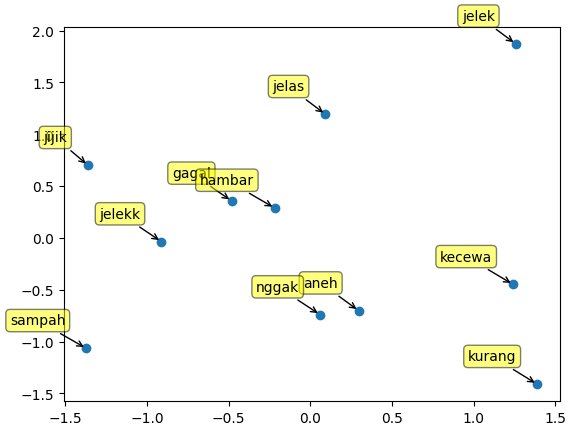

In [20]:
plot(red_word_vectors, word_list)

## FastText (Pre-Trained Model)
Pada contoh Word2Vec diatas, kita melatih suatu shallow neural network pada dataset Sentiment opini twitter untuk mendapatkan word vectors. Pada contoh FastText ini, kita akan memanfaatkan pre-trained word vector yang sudah dilatih pada kumpulan data yang besar.

In [37]:
!pip -q install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [38]:
# Download dan unzip dataset
# Warning: proses download lama dan memakan diskspace yang besar (sekitar 7GB)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2023-04-10 13:36:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.108, 99.84.160.61, 99.84.160.46, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   143MB/s    in 31s     

2023-04-10 13:37:11 (137 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [1]:
import fasttext

# Load model FastText
ft_model = fasttext.load_model("cc.en.300.bin")

In [21]:
# Lihat vektor kata tertentu menggunakan pre-trained FastText
print(ft_model['jelek'])

[ 4.87347953e-02 -6.18389100e-02 -1.06862690e-02  8.64317566e-02
 -1.61089152e-02 -5.44473194e-02 -3.61784622e-02  2.70135514e-02
 -4.31752801e-02  2.24330425e-02  7.87730422e-03 -3.06462236e-02
 -5.49236163e-02 -1.09569794e-02 -1.49083715e-02 -5.17619252e-02
  8.56937096e-03 -1.63274887e-03 -3.98649424e-02  3.29479836e-02
 -1.70728564e-03  6.20365441e-02 -5.20510226e-02  8.83138366e-03
  4.96607237e-02  3.03728390e-03 -3.41918366e-03 -2.87652458e-03
  3.75174582e-02  4.87564206e-02 -9.82742198e-03  1.52032897e-02
  5.05408412e-03  1.50449341e-02  2.77260058e-02  4.86840978e-02
  4.47439924e-02  7.09263161e-02 -4.81355302e-02 -3.70732136e-03
 -1.10075045e-02 -7.48849940e-03 -2.00037844e-02 -2.46034320e-02
  6.98853424e-03  6.58441707e-02  4.38647568e-02 -1.13620609e-03
 -4.63176183e-02 -2.39258260e-03 -2.36989255e-03 -3.68800908e-02
  3.12901381e-03 -3.01650129e-02  3.60246226e-02 -2.44609527e-02
  5.27017191e-03  4.14020680e-02 -2.59261113e-02 -2.48237606e-02
  5.53342775e-02 -2.42192

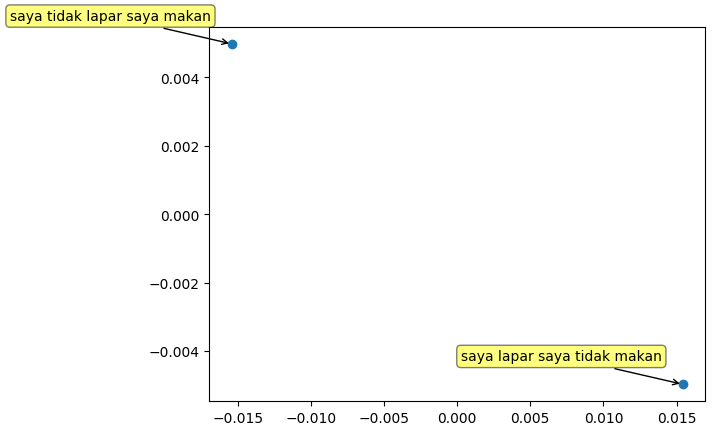

In [22]:
list_kalimat = ['saya lapar saya tidak makan', 'saya tidak lapar saya makan'] 
word_vectors_fasttext = np.array([ft_model[w] for w in list_kalimat])
pca = PCA(n_components=2, copy=False, whiten=True) # Proses reduksi dimensi

fasttext_word_vectors = pca.fit_transform(word_vectors_fasttext)

plot(word_vectors_fasttext, list_kalimat)

# 06 Deep Learning for NLP

## Long short term memory network (LSTM)

### Memilih Panjang Sequence (max_length)

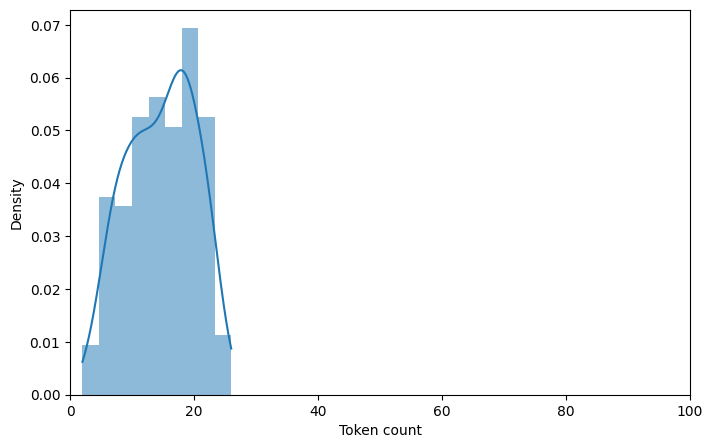

In [23]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for text in data['clean_teks']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [24]:
MAX_SEQ_LENGTH = 60

### Preparing Data for Embedding Layer

#### Tokenizing Data
Proses ini berbeda dengan tokenization pada text-preprocessing. Pada pemodelan dengan deep learning, tokenization merujuk pada membuat dictionary berdasarkan dataset.

In [25]:
'''
Proses vektorisasi teks dengan mengubah setiap teks menjadi token urutan bilangan int (setiap bilangan int menjadi indeks token dalam dictionary) 
'''
from keras.preprocessing.text import Tokenizer

In [26]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(data['clean_teks'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

1139


In [27]:
# Lihat dictionary hasil tokenisasi
WV_DICTIONARY

{'<unk>': 1,
 'film': 2,
 'nonton': 3,
 'ini': 4,
 'yg': 5,
 'yang': 6,
 'dan': 7,
 'di': 8,
 'kartini': 9,
 'bagus': 10,
 'kecewa': 11,
 'banget': 12,
 'the': 13,
 'keren': 14,
 'jelek': 15,
 'sama': 16,
 'ada': 17,
 'itu': 18,
 'bikin': 19,
 'dari': 20,
 'ga': 21,
 'jadi': 22,
 'guys': 23,
 'juga': 24,
 'nya': 25,
 'saya': 26,
 'indonesia': 27,
 'filmnya': 28,
 'danur': 29,
 'kurang': 30,
 'ya': 31,
 'parah': 32,
 'banyak': 33,
 'gak': 34,
 'dengan': 35,
 'ditonton': 36,
 'gue': 37,
 'agak': 38,
 'aku': 39,
 'sih': 40,
 'aja': 41,
 'sangat': 42,
 'bgt': 43,
 'radityadika': 44,
 'tapi': 45,
 'bisa': 46,
 'tp': 47,
 'ternyata': 48,
 'abis': 49,
 'buat': 50,
 'untuk': 51,
 'tonton': 52,
 'bang': 53,
 'suka': 54,
 'salah': 55,
 'satu': 56,
 'criticaleleven': 57,
 'apa': 58,
 'baru': 59,
 'lagi': 60,
 'bilang': 61,
 'dgn': 62,
 'bioskop': 63,
 'critical': 64,
 'kita': 65,
 'kalo': 66,
 'karena': 67,
 'lebih': 68,
 'hanungbramantyo': 69,
 'filmziarah': 70,
 'cerita': 71,
 'harus': 72,
 'ad

#### Text to Sequence

In [28]:
# Proses mengubah token hasil tokenisasi menjadi urutan bilangan int berdasarkan index dictionary.
data_seq = tokenizer.texts_to_sequences(data['clean_teks'])

In [29]:
# Lihat hasil setelah di ubah menjadi sequences
print(data['clean_teks'][10])
print(data_seq[10])

film jelek jelas ga ada isinya
[2, 15, 88, 21, 17, 1]


#### Add Padding & Truncation

In [35]:
'''
Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
num_timesteps adalah argumen maxlen jika disediakan, atau panjang dari sequence terpanjang dalam daftar.

Sequence yang lebih pendek dari num_timesteps diisi dengan nilai hingga panjangnya sama dengan num_timesteps (padding).
Sequence yang lebih panjang dari num_timesteps dipotong sehingga sesuai dengan panjang yang diinginkan (truncate).
'''

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
PADDING = 'post'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'post'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [37]:
print(data['clean_teks'][10])
print(data_seq[10])
print(data_pad[10])

film jelek jelas ga ada isinya
[2, 15, 88, 21, 17, 1]
[ 2 15 88 21 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


### One-hot Encoding

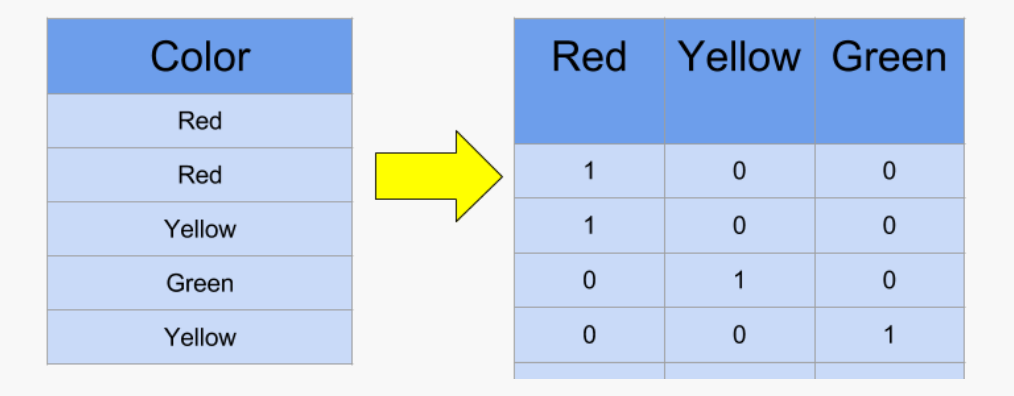

In [50]:
from tensorflow.keras.utils import to_categorical

Y = to_categorical(data['label'], num_classes=len(data['label'].unique()))  # Lakukan one-hot encoding pada label (y)

In [ ]:
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Train & Test Data Splitting

In [51]:
# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data_pad, Y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 60), (40, 60), (160, 2), (40, 2))

### Define Model Architecture (LSTM)



In [56]:
'''
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

model_LSTM = Sequential()
model_LSTM.add(Embedding(                                           # Buat embedding layer yang menerima panjang dictionary hasil Tokenisasi
    input_dim = WV_DICTIONARY_SIZE,
    input_length = MAX_SEQ_LENGTH,
    output_dim = 64))      
model_LSTM.add(LSTM(64))                                            # Tambahkan satu layer LSTM
model_LSTM.add(Dropout(0.5))                             
model_LSTM.add(Dense(2, activation='softmax'))

In [57]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 64)            72896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 106,050
Trainable params: 106,050
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Compile model
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [59]:
%%time

EPOCH = 10
BATCH_SIZE = 32

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/10
5/5 [==============================] - 10s 407ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 0s 63ms/step - loss: 0.6969 - accuracy: 0.4375 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 1s 107ms/step - loss: 0.6938 - accuracy: 0.5625 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 0s 110ms/step - loss: 0.6922 - accuracy: 0.5250 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 0s 62ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 0s 15ms/step - loss: 0.6993 - accuracy: 0.3625 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 0s 17ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
5/5 [=======

In [60]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

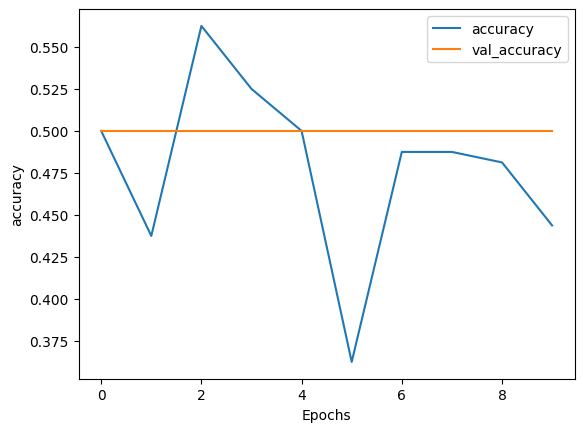

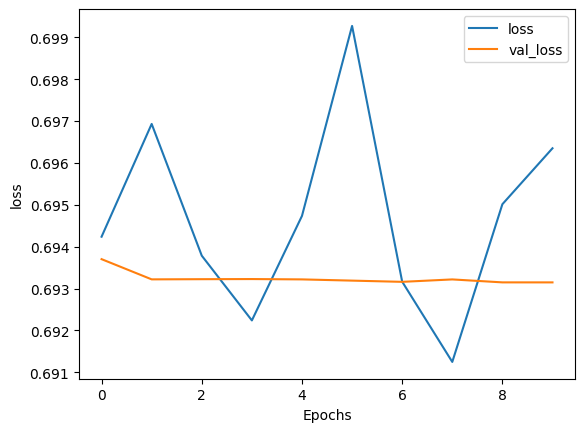

In [61]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [62]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.500000 	   0.694238 	   0.500000 	   0.693701
       2   0.437500 	   0.696932 	   0.500000 	   0.693219
       3   0.562500 	   0.693784 	   0.500000 	   0.693223
       4   0.525000 	   0.692238 	   0.500000 	   0.693226
       5   0.500000 	   0.694735 	   0.500000 	   0.693218
       6   0.362500 	   0.699274 	   0.500000 	   0.693189
       7   0.487500 	   0.693163 	   0.500000 	   0.693159
       8   0.487500 	   0.691246 	   0.500000 	   0.693217
       9   0.481250 	   0.695014 	   0.500000 	   0.693147
      10   0.443750 	   0.696351 	   0.500000 	   0.693146


### Evaluate

In [63]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_LSTM.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.5000


In [64]:
from sklearn.metrics import classification_report

# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67        40

    accuracy                           0.50        40
   macro avg       0.50      0.25      0.33        40
weighted avg       1.00      0.50      0.67        40



## Bidirectional Long short term memory network (Bi-LSTM) + Word2Vec
Contoh sebelumnya kita hanya menggunakan dictionary yang dihasilkan ketika proses Tokenizing. Lalu, ketika pemodelan ditambahkan layer embedding sebelum di fitkan ke layer LSTM.


Selanjutnya, kita akan memanfaatkan word2vec yang telah dilatih pada proses sebelumnya untuk mengubah teks menjadi bentuk vektor.





### Load Word2Vec

In [72]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.key_to_index     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

1137
100


In [74]:
word2vec_dict = {}

for word in my_word2vec_vocab:
    word2vec_dict[word] = my_word2vec.get_vector(word)   
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # Harus sama dengan ukuran vocab word2vec

The numbers of key-value pairs:  1137


### Create Embedding Matrix

In [75]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [76]:
# Cek index keberapa di Word2Vec vocabulary dari suatu kata
print(WV_DICTIONARY.get('saya'))

26


In [77]:
# Cek vector dari suatu kata
print(EMBEDDING_MATRIX[25])

[-0.0476289   0.10997157  0.03992592  0.00143275 -0.00453392 -0.26539031
  0.06311315  0.37645343 -0.07447312 -0.06568267 -0.10768366 -0.17868687
 -0.0294651   0.05265987 -0.05746562 -0.06519563  0.05240962 -0.14506049
 -0.07584798 -0.26526743  0.09094661  0.12245857  0.05423271 -0.03228604
 -0.06451639  0.04895025 -0.11908206 -0.0435498  -0.1317616   0.0115911
  0.17111231 -0.04680804  0.14435403 -0.08573423 -0.12830622  0.11940148
 -0.00479121 -0.18502435 -0.1277198  -0.2369905   0.02662837 -0.15454245
 -0.03140112 -0.04594766  0.15250547 -0.0806079  -0.12350003 -0.03608945
  0.09994729  0.09644632  0.12198801 -0.03830059 -0.04563521 -0.06613531
 -0.05200972  0.13802168  0.04182606 -0.05821284 -0.14429782 -0.00249457
 -0.04624857  0.00091228 -0.00549907 -0.03396767 -0.215592    0.16360228
  0.0265943   0.10894934 -0.26366323  0.08975785 -0.09221206  0.01687112
  0.16573457 -0.07361092  0.13668486  0.03433223  0.04913815 -0.0351552
 -0.13505958  0.02974879 -0.09565928 -0.01891632 -0.1

In [78]:
# Cek dimensi word vector. X = jumlah kata pada vocabulary, y = dimensi vektor
EMBEDDING_MATRIX.shape

(1139, 100)

### Define Model (Bi LSTM)
Nah, sekarang kita membahkan layer embedding berdasarkan matrix embedding yang di dapatkan dari word2vec yang sudah kita latih sebelumnya. Selain itu, kita akan mencoba menggunakan arsitektur Bidirectional LSTM.

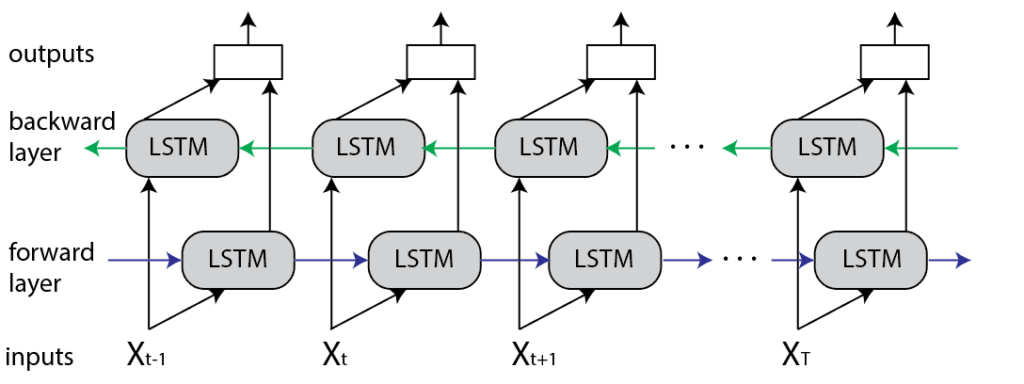



In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.initializers import Constant

model_BiLSTM_w2v = Sequential()
model_BiLSTM_w2v.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    trainable = False,
    embeddings_initializer = Constant(EMBEDDING_MATRIX)))
model_BiLSTM_w2v.add(Bidirectional(LSTM(64)))
model_LSTM.add(Dropout(0.5))  
model_BiLSTM_w2v.add(Dense(2, activation='softmax'))

In [84]:
model_BiLSTM_w2v.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 100)           113900    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 198,638
Trainable params: 84,738
Non-trainable params: 113,900
_________________________________________________________________


In [85]:
# Compile model
model_BiLSTM_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [87]:
%%time

EPOCH = 10
BATCH_SIZE = 32

history_BiLSTM_w2v = model_BiLSTM_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/10
5/5 [==============================] - 0s 27ms/step - loss: 0.6666 - accuracy: 0.6375 - val_loss: 0.7067 - val_accuracy: 0.4750
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 0.6652 - accuracy: 0.6187 - val_loss: 0.7114 - val_accuracy: 0.4750
Epoch 3/10
5/5 [==============================] - 0s 18ms/step - loss: 0.6641 - accuracy: 0.6000 - val_loss: 0.7132 - val_accuracy: 0.4500
Epoch 4/10
5/5 [==============================] - 0s 18ms/step - loss: 0.6616 - accuracy: 0.6187 - val_loss: 0.7162 - val_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6592 - accuracy: 0.6125 - val_loss: 0.7173 - val_accuracy: 0.4250
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.6653 - accuracy: 0.6062 - val_loss: 0.7271 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 0s 17ms/step - loss: 0.6584 - accuracy: 0.6000 - val_loss: 0.7230 - val_accuracy: 0.4750
Epoch 8/10
5/5 [===========

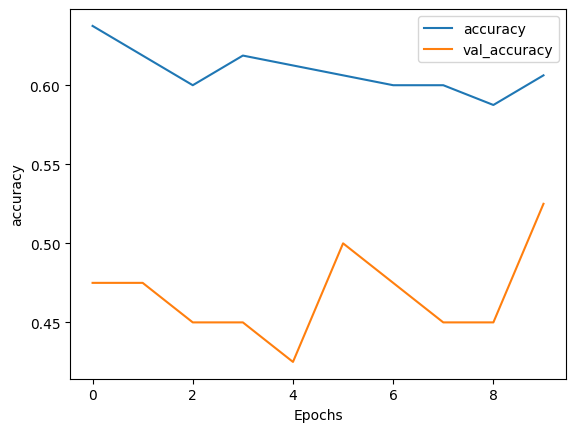

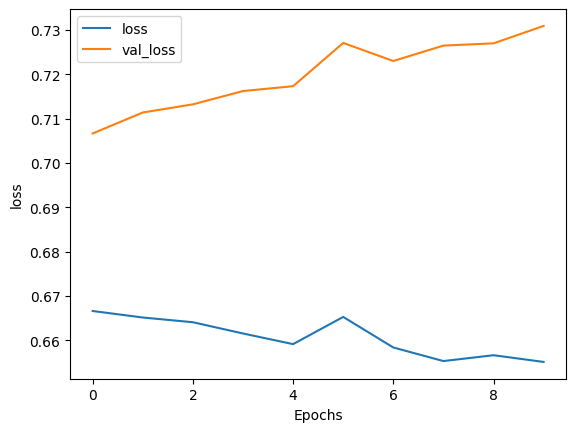

In [88]:
plot_graphs(history_BiLSTM_w2v, 'accuracy')
plot_graphs(history_BiLSTM_w2v, 'loss')

In [89]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_BiLSTM_w2v.history['accuracy'][i], history_BiLSTM_w2v.history['loss'][i], history_BiLSTM_w2v.history['val_accuracy'][i], history_BiLSTM_w2v.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.637500 	   0.666632 	   0.475000 	   0.706664
       2   0.618750 	   0.665165 	   0.475000 	   0.711392
       3   0.600000 	   0.664102 	   0.450000 	   0.713233
       4   0.618750 	   0.661563 	   0.450000 	   0.716228
       5   0.612500 	   0.659164 	   0.425000 	   0.717324
       6   0.606250 	   0.665301 	   0.500000 	   0.727077
       7   0.600000 	   0.658408 	   0.475000 	   0.723000
       8   0.600000 	   0.655345 	   0.450000 	   0.726475
       9   0.587500 	   0.656663 	   0.450000 	   0.726985
      10   0.606250 	   0.655152 	   0.525000 	   0.730913


### Evaluate

In [90]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_BiLSTM_w2v.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_BiLSTM_w2v.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.7309 - accuracy: 0.5250


In [91]:
# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.60      0.52      0.56        23
           1       0.45      0.53      0.49        17

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.54      0.53      0.53        40

